# Import libs

In [69]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import random
plt.rcParams['figure.figsize'] = 15, 10

# Loading Data

In [10]:
# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5))
])
  
# Downloading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="/content/drive/MyDrive/DeepLearning/CV/HW1", train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False)
  
test_dataset = torchvision.datasets.MNIST(
    root="/content/drive/MyDrive/DeepLearning/CV/HW1", train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False)

device = torch.device("cuda")
# Creating Dataloaders from the
# training and testing dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128)

# Autoencoder

In [5]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
  
# Instantiating the model and hyperparameters
model = DeepAutoencoder().to(device)
criterion = torch.nn.MSELoss()
num_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 30/30 [03:20<00:00,  6.67s/it]


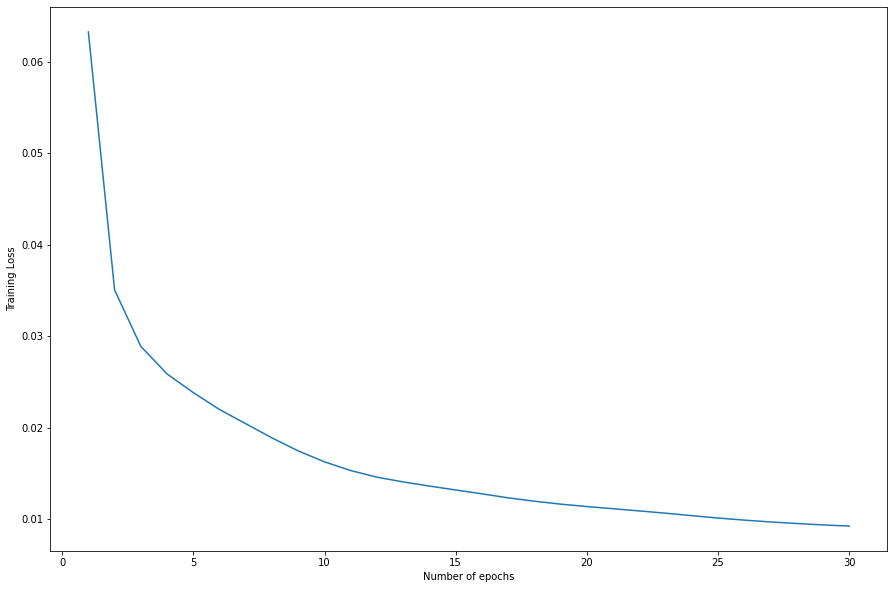

In [6]:
# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}
  
batch_size = len(train_loader)
  
# Training loop starts
for epoch in tqdm(range(num_epochs)):
        
    # Initializing variable for storing 
    # loss
    running_loss = 0
      
    # Iterating over the training dataset
    for batch in train_loader:
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img, _ = batch  
        img = img.reshape(-1, 28*28).to(device)
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img)
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

# Classifier

In [7]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [31]:
import torch.optim as optim
num_epochs = 45
encoder = model.encoder
# Create model, loss function, and optimizer
model_LinearClassifier = LinearClassifier(input_dim=32, num_classes=10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

loss_lis = []
running_loss = 0

# Train the model
for epoch in tqdm(range(num_epochs)):

    running_loss = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        img = inputs.reshape(-1, 28*28).to(device)
        feature = encoder(img).to(device)
        outputs = model_LinearClassifier(feature).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= batch_size
    loss_lis.append(running_loss)


100%|██████████| 45/45 [04:26<00:00,  5.92s/it]


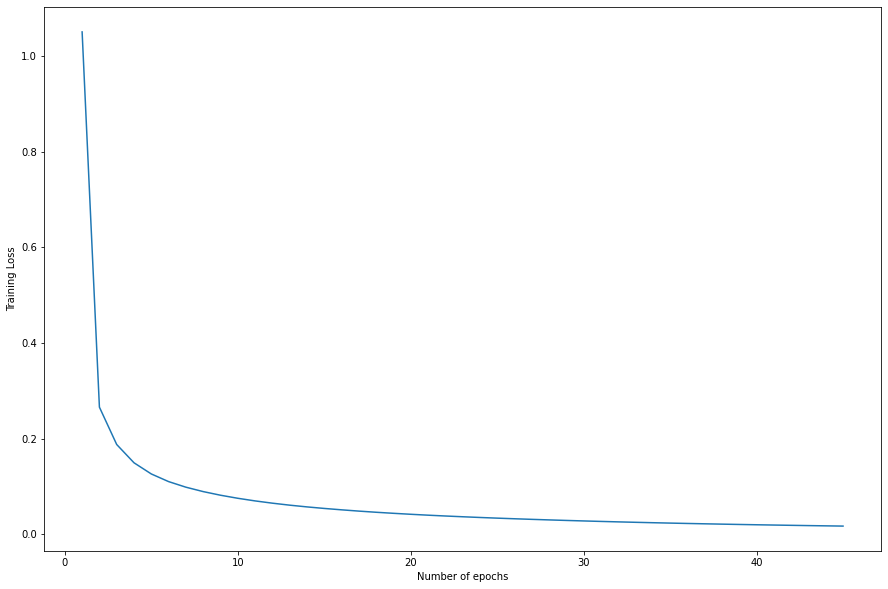

In [32]:
# Plotting the training loss
plt.plot(range(1,num_epochs+1),loss_lis)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

In [48]:

# Get predictions for test data
y_pred = []
y_test = []
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.to(device)
        for y in labels:
          y_test.append([y.cpu().numpy()])
        img = inputs.reshape(-1, 28*28).to(device)
        feature = encoder(img)
        outputs = model_LinearClassifier(feature)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        


# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))


Accuracy: 97.72%


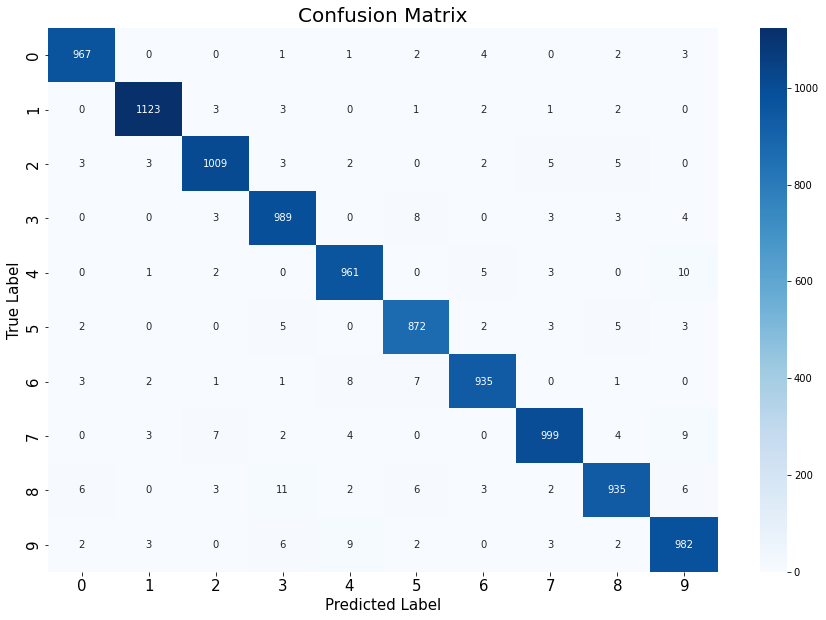

In [56]:
# Plot confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Add title and x, y labels
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)

# Increase the font size of the labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.show()

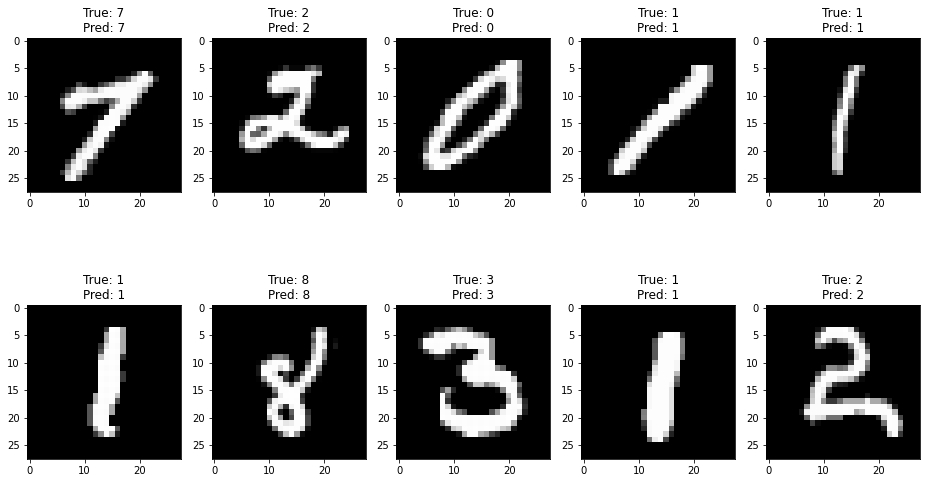

In [72]:
# Get random indexes from test set
random_indexes = random.sample(range(0, len(test_loader.dataset)), 10)

# Plot 10 random test images
fig, ax = plt.subplots(2, 5, figsize=(16, 9))
for i, index in enumerate(random_indexes):
    test_img, test_label = test_loader.dataset[index]
    test_img = test_img.reshape(-1, 28*28).to(device)
    feature = encoder(test_img).to(device)
    prediction = model_LinearClassifier(feature)
    _, prediction = torch.max(prediction.data, 1)
    ax[i//5][i%5].imshow(test_img.reshape(28, 28).cpu(), cmap='gray')
    ax[i//5][i%5].set_title("True: " + str(test_label) + "\nPred: " + str(prediction.item()))
plt.show()